In [70]:
import pandas as pd
import numpy as np

In [71]:
bookdf = pd.read_csv("/Users/YukiZ./Desktop/565/book_clean_data.csv")

In [72]:
bookdf

,Unnamed: 0,Title,Cleaned_Plot
0,0,The Day of the Pelican,story fictional family family living midst war...
1,1,The Lost World of British Communism,book composed series collected together mark t...
2,2,Village of Secrets,book narrative regarding role village sur east...
3,3,Gods Without Men,although many geographically temporally action...
4,4,The Women of the Cousins' War,book introduction three biographical first wri...
...,...,...,...
18172,18172,La Bastarda,orphan born bastard whose mother childbirth tr...
18173,18173,Seeing with the Eyes of Love,imitation devotional book written ca work seei...
18174,18174,Star Wars Republic Commando: Order 66,tur finally son guise grandchild one biologica...
18175,18175,Getting It: The Psychology of est,book divided two first section training second...


In [73]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('wordnet')
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package wordnet to /Users/YukiZ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
#Lemmatization and stemming plus words less than 3 or equals to 3 token cutoff 
def lemmatize_stemming(text, stemmer):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def preprocess(text, stemmer):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    result = []
    for token in word_tokenize(text.lower()):
        eng_stopwords = set(stopwords.words('english'))
        if token not in eng_stopwords and len(token) >= 3:
            result.append(lemmatize_stemming(token, stemmer))
    return result

In [93]:
text = bookdf['Cleaned_Plot'].astype(str)
stemmer = PorterStemmer()
result = []
for i in range(len(text)):
    result.append(preprocess(text[i], stemmer))

In [94]:
## Bag of Words Prep
dictionary = gensim.corpora.Dictionary(result)

In [95]:
##If remove very rare and very common words
# - words appearing less than 3 times
# - words appearing in more than 10% of all documents
# - words appearing frequently rank before 10th 
#dictionary.filter_extremes(no_below=3, no_above=0.1, keep_n= 10)

In [169]:
bow_corpus = [dictionary.doc2bow(doc) for doc in result]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 4),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2)]

In [98]:
bookdf['Cleaned_Plot'][0]

'story fictional family family living midst war family suddenly homeless middle violent war enduring much hardship hunger illness dangerous journey escape situation church group find small town take place path family'

In [97]:
## Preview the bag of words result for first book plot 
bow_doc_x = bow_corpus[0]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("church") appears 1 time.
Word 1 ("danger") appears 1 time.
Word 2 ("endur") appears 1 time.
Word 3 ("escap") appears 1 time.
Word 4 ("famili") appears 4 time.
Word 5 ("fiction") appears 1 time.
Word 6 ("find") appears 1 time.
Word 7 ("group") appears 1 time.
Word 8 ("hardship") appears 1 time.
Word 9 ("homeless") appears 1 time.
Word 10 ("hunger") appears 1 time.
Word 11 ("ill") appears 1 time.
Word 12 ("journey") appears 1 time.
Word 13 ("live") appears 1 time.
Word 14 ("middl") appears 1 time.
Word 15 ("midst") appears 1 time.
Word 16 ("much") appears 1 time.
Word 17 ("path") appears 1 time.
Word 18 ("place") appears 1 time.
Word 19 ("situat") appears 1 time.
Word 20 ("small") appears 1 time.
Word 21 ("stori") appears 1 time.
Word 22 ("suddenli") appears 1 time.
Word 23 ("take") appears 1 time.
Word 24 ("town") appears 1 time.
Word 25 ("violent") appears 1 time.
Word 26 ("war") appears 2 time.


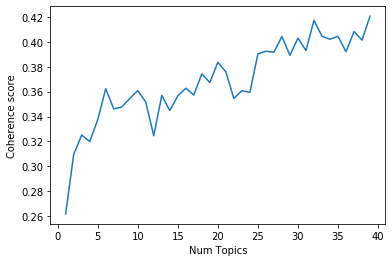

In [99]:
##Coherence plot for LDA topic modeling CV
def scores_plot():
    scores = []
    for i in range(1,40):
        lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, 
                                                num_topics=i, 
                                                id2word=dictionary, 
                                                passes=2)
        cm = CoherenceModel(model=lda_model,texts = result, corpus=bow_corpus, coherence='c_v')
        coherence = cm.get_coherence()
        scores.append(coherence)
    limit=40; start=1; step=1;
    x = range(start, limit, step)
    plt.plot(x, scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")

scores_plot()
##Roughly 14 is optimist # of topics 

In [100]:
def lda_model(i, bow_corpus, dictionary):
    lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, 
                                            num_topics=i,
                                            id2word=dictionary, 
                                            passes=2)
    return lda_model

In [154]:
lda_model32 = lda_model(32, bow_corpus, dictionary)

In [155]:
# print 32 topics
for idx, topic in lda_model32.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"street" + 0.010*"park" + 0.009*"get" + 0.008*"man" + 0.008*"laura" + 0.007*"ray" + 0.007*"angel" + 0.007*"town" + 0.007*"beth" + 0.007*"gang"
Topic: 1 
Words: 0.036*"jack" + 0.010*"hospit" + 0.010*"find" + 0.009*"carver" + 0.009*"bodi" + 0.007*"diseas" + 0.006*"one" + 0.006*"time" + 0.006*"bat" + 0.005*"patient"
Topic: 2 
Words: 0.067*"henri" + 0.022*"chocol" + 0.016*"fan" + 0.015*"tae" + 0.015*"rubi" + 0.011*"salli" + 0.010*"fang" + 0.009*"carol" + 0.008*"bean" + 0.008*"unsaf"
Topic: 3 
Words: 0.095*"grace" + 0.042*"lewi" + 0.028*"clay" + 0.028*"marqui" + 0.026*"van" + 0.022*"god" + 0.019*"memoir" + 0.018*"heather" + 0.018*"angel" + 0.015*"museum"
Topic: 4 
Words: 0.036*"ship" + 0.023*"captain" + 0.021*"island" + 0.020*"sea" + 0.018*"crew" + 0.010*"mine" + 0.009*"take" + 0.008*"find" + 0.008*"bond" + 0.007*"command"
Topic: 5 
Words: 0.029*"earth" + 0.021*"planet" + 0.012*"space" + 0.012*"human" + 0.009*"one" + 0.009*"time" + 0.009*"world" + 0.008*"alien" + 0.00

In [127]:
lda_model28 = lda_model(28, bow_corpus, dictionary)

In [128]:
# print 28 topics
for idx, topic in lda_model28.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"one" + 0.009*"find" + 0.009*"hous" + 0.009*"father" + 0.008*"leav" + 0.008*"home" + 0.008*"back" + 0.008*"take" + 0.008*"mother" + 0.008*"see"
Topic: 1 
Words: 0.011*"ship" + 0.010*"king" + 0.009*"take" + 0.008*"kill" + 0.007*"battl" + 0.007*"return" + 0.007*"one" + 0.007*"find" + 0.007*"armi" + 0.006*"back"
Topic: 2 
Words: 0.020*"govern" + 0.016*"white" + 0.011*"book" + 0.010*"chapter" + 0.010*"dictionari" + 0.010*"econom" + 0.009*"feder" + 0.009*"peopl" + 0.009*"also" + 0.008*"new"
Topic: 3 
Words: 0.020*"book" + 0.010*"chapter" + 0.009*"work" + 0.009*"also" + 0.007*"use" + 0.007*"social" + 0.007*"natur" + 0.007*"cultur" + 0.007*"human" + 0.006*"section"
Topic: 4 
Words: 0.069*"novel" + 0.015*"stori" + 0.015*"life" + 0.013*"famili" + 0.012*"charact" + 0.010*"film" + 0.010*"death" + 0.010*"father" + 0.010*"set" + 0.009*"plot"
Topic: 5 
Words: 0.020*"planet" + 0.017*"war" + 0.013*"earth" + 0.009*"govern" + 0.009*"empir" + 0.008*"militari" + 0.008*"world" + 0.00

In [107]:
def format_topics_sentences(lda_model, bow_corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[bow_corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [156]:
########################### 32 topics ####################
# Calculate each document sentence dominant topic and contribution
final_result = format_topics_sentences(lda_model32,bow_corpus, text )
final_result

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Cleaned_Plot
0,17.0,0.4659,"love, marri, son, daughter, becom, famili, you...",story fictional family family living midst war...
1,27.0,0.3024,"book, chapter, also, first, section, includ, h...",book composed series collected together mark t...
2,16.0,0.4723,"war, govern, unit, presid, armi, militari, new...",book narrative regarding role village sur east...
3,15.0,0.5545,"novel, stori, life, narrat, write, first, book...",although many geographically temporally action...
4,27.0,0.3517,"book, chapter, also, first, section, includ, h...",book introduction three biographical first wri...
...,...,...,...,...
18172,11.0,0.3964,"school, mother, famili, father, new, home, bec...",orphan born bastard whose mother childbirth tr...
18173,15.0,0.4033,"novel, stori, life, narrat, write, first, book...",imitation devotional book written ca work seei...
18174,5.0,0.4495,"earth, planet, space, human, one, time, world,...",tur finally son guise grandchild one biologica...
18175,12.0,0.4254,"human, time, world, use, new, one, control, ma...",book divided two first section training second...


In [157]:
def sentence_keyword(final_result):
    con = final_result.groupby("Dominant_Topic")
    new = pd.DataFrame()
    for i, grp in con:
        new = pd.concat([new, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)
    new.reset_index(drop=True, inplace=True)
    new.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    new = new.drop(['Topic_Perc_Contrib'], axis=1)
    return new

In [158]:
# Find the most representative sentence to the topics
sentence_keyword32 = sentence_keyword(final_result)
sentence_keyword32

,Topic_Num,Keywords,Text
0,0.0,"street, park, get, man, laura, ray, angel, tow...",pentecostal pastor god touched article life ma...
1,1.0,"jack, hospit, find, carver, bodi, diseas, one,...",woman digging dinosaur bone bed remote wildern...
2,2.0,"henri, chocol, fan, tae, rubi, salli, fang, ca...",wine update book first wine brand new original...
3,3.0,"grace, lewi, clay, marqui, van, god, memoir, h...",book seventeen year old runaway hired track ru...
4,4.0,"ship, captain, island, sea, crew, mine, take, ...",mystery two missing curio collection wind deso...
5,5.0,"earth, planet, space, human, one, time, world,...",part earth away bottleneck ice thin air catchi...
6,6.0,"peopl, social, econom, book, polit, societi, w...",studied performance twenty regional since simi...
7,7.0,"king, magic, queen, castl, princ, palac, land,...",small island kingdom sat middle precariously b...
8,8.0,"doctor, jane, time, ami, machin, master, brain...",planet insect like alien man hook hand head ca...
9,9.0,"ben, clark, wolf, tranquil, robin, dick, one, ...",taking place world war two community come acro...


In [159]:
##Model Evaluation 

In [160]:
#Split plots to first and second half
first = [plot[:np.int0(len(plot)/2)] for plot in result]
second = [plot[np.int0(len(plot)/2):] for plot in result]

In [161]:
corpus_1 = [dictionary.doc2bow(plot) for plot in first]
corpus_2 = [dictionary.doc2bow(plot) for plot in second]

In [162]:
lda_corpus_1 = lda_model14[corpus_1]
lda_corpus_2 = lda_model14[corpus_2]

In [163]:
from collections import OrderedDict
num_topics = 32
def article_topic_dist(model, corpus, kwords=False):
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

In [164]:
from sklearn.metrics.pairwise import cosine_similarity
top_dist_1, _ = article_topic_dist(lda_model20, lda_corpus_1)
top_dist_2, _ = article_topic_dist(lda_model20, lda_corpus_2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist_1, top_dist_2)]))

random_pairs = np.random.randint(0, len(result), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist_1[i[0]].reshape(1, -1), top_dist_2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.6257538
Inter similarity: cosine similarity between random parts (lower is better):
0.4131888


In [129]:
########################### 28 topics ####################
# Calculate each document sentence dominant topic and contribution
final_result = format_topics_sentences(lda_model28,bow_corpus, text )
final_result

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Cleaned_Plot
0,4.0,0.3617,"novel, stori, life, famili, charact, film, dea...",story fictional family family living midst war...
1,11.0,0.5165,"book, write, war, stori, first, new, novel, wo...",book composed series collected together mark t...
2,3.0,0.2324,"book, chapter, work, also, use, social, natur,...",book narrative regarding role village sur east...
3,23.0,0.3262,"life, love, one, becom, live, work, time, peop...",although many geographically temporally action...
4,11.0,0.3814,"book, write, war, stori, first, new, novel, wo...",book introduction three biographical first wri...
...,...,...,...,...
18172,27.0,0.6508,"famili, becom, father, mother, marri, son, sch...",orphan born bastard whose mother childbirth tr...
18173,23.0,0.7565,"life, love, one, becom, live, work, time, peop...",imitation devotional book written ca work seei...
18174,27.0,0.3161,"famili, becom, father, mother, marri, son, sch...",tur finally son guise grandchild one biologica...
18175,7.0,0.7919,"time, one, human, part, first, earth, make, pe...",book divided two first section training second...


In [130]:
def sentence_keyword(final_result):
    con = final_result.groupby("Dominant_Topic")
    new = pd.DataFrame()
    for i, grp in con:
        new = pd.concat([new, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)
    new.reset_index(drop=True, inplace=True)
    new.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    new = new.drop(['Topic_Perc_Contrib'], axis=1)
    return new

In [131]:
# Find the most representative sentence to the topics
sentence_keyword28 = sentence_keyword(final_result)
sentence_keyword28

,Topic_Num,Keywords,Text
0,0.0,"one, find, hous, father, leav, home, back, tak...",every day life jake struggle due horrible viol...
1,1.0,"ship, king, take, kill, battl, return, one, fi...",newly leaf capital travel among desert sword b...
2,2.0,"govern, white, book, chapter, dictionari, econ...",century panic within economic system since eve...
3,3.0,"book, chapter, work, also, use, social, natur,...",essay cultural industry expression mass cultur...
4,4.0,"novel, stori, life, famili, charact, film, dea...",novel story bret travelled bring young wife st...
5,5.0,"planet, war, earth, govern, empir, militari, w...",apprentice obi wan faced leader sith cult gene...
6,6.0,"rise, captain, jean, clan, fox, blake, ice, lu...",nan
7,7.0,"time, one, human, part, first, earth, make, pe...",previously time discovered advanced form breas...
8,8.0,"magic, book, world, new, also, set, nine, firs...",sea people creature crucible supplement campai...
9,9.0,"clone, brazil, concord, drake, robot, sri, str...",one several plantation literature genre reacti...


In [132]:
##Model Evaluation 
#Split plots to first and second half
first = [plot[:np.int0(len(plot)/2)] for plot in result]
second = [plot[np.int0(len(plot)/2):] for plot in result]

In [133]:
corpus_1 = [dictionary.doc2bow(plot) for plot in first]
corpus_2 = [dictionary.doc2bow(plot) for plot in second]

In [134]:
lda_corpus28_1 = lda_model28[corpus_1]
lda_corpus28_2 = lda_model28[corpus_2]

In [165]:
from collections import OrderedDict
num_topics = 28
def article_topic_dist(model, corpus, kwords=False):
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

In [166]:
from sklearn.metrics.pairwise import cosine_similarity
top_dist_1, _ = article_topic_dist(lda_model28, lda_corpus28_1)
top_dist_2, _ = article_topic_dist(lda_model28, lda_corpus28_2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist_1, top_dist_2)]))

random_pairs = np.random.randint(0, len(result), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist_1[i[0]].reshape(1, -1), top_dist_2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.3796881
Inter similarity: cosine similarity between random parts (lower is better):
0.19583462


In [ ]:
################### ---- LSA ---- #################

In [195]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from gensim import corpora, models

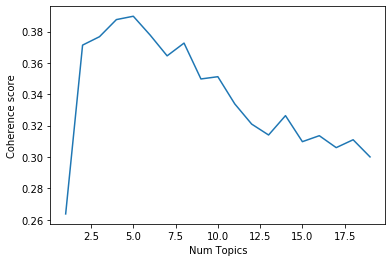

In [172]:
def scores_plot():
    scores = []
    for i in range(1,20):
        lsa_model = LsiModel(bow_corpus, 
                             num_topics=i, 
                             id2word=dictionary)
        cm = CoherenceModel(model= lsa_model,texts = result, corpus=bow_corpus, coherence='c_v')
        coherence = cm.get_coherence()
        scores.append(coherence)
    limit=20; start=1; step=1;
    x = range(start, limit, step)
    plt.plot(x, scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
scores_plot()

In [196]:
def lsa_model(i, bow_corpus, dictionary):
    lsa_model = models.LsiModel(bow_corpus, 
                         num_topics=i,
                         id2word=dictionary)
    return lsa_model

In [197]:
lsa_model5 = lsa_model(5, bow_corpus, dictionary)

In [203]:
for idx, topic in lsa_model5.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.216*"find" + 0.186*"take" + 0.178*"one" + 0.146*"leav" + 0.134*"tell" + 0.134*"time" + 0.132*"kill" + 0.130*"make" + 0.121*"return" + 0.116*"becom"
Topic: 1 
Words: 0.729*"doctor" + 0.138*"tardi" + -0.133*"mother" + -0.129*"famili" + -0.127*"father" + 0.122*"ship" + 0.116*"kill" + 0.107*"use" + -0.093*"love" + 0.093*"find"
Topic: 2 
Words: -0.270*"book" + 0.194*"tell" + -0.182*"world" + 0.179*"find" + -0.179*"human" + 0.173*"doctor" + -0.138*"war" + 0.137*"get" + 0.133*"mother" + -0.132*"state"
Topic: 3 
Words: -0.512*"doctor" + 0.270*"kill" + -0.217*"book" + 0.146*"ship" + -0.144*"time" + 0.139*"find" + -0.135*"mother" + 0.128*"attack" + -0.126*"stori" + -0.126*"famili"
Topic: 4 
Words: -0.283*"book" + 0.221*"father" + -0.214*"get" + 0.202*"famili" + -0.187*"find" + -0.178*"tell" + 0.171*"becom" + 0.161*"son" + 0.144*"marri" + -0.138*"go"
